# Synthetic Microtubule Image Generation Pipeline

This notebook provides a detailed walkthrough of the synthetic microscopy image generation pipeline.
The pipeline generates realistic microtubule (MT) images with corresponding instance segmentation masks,
following a **two-step stochastic process** that produces images $I \sim P_\theta(I)$ conditioned on a parameter set $\theta$.

## Overview

The generation process consists of:

1. **Geometry Generation** – Creating microtubule morphology using polylines with stochastic curvature
2. **Image Rendering** – Applying physical optics (PSF convolution) and realistic imaging artifacts

The second step is further divided into:
- **(2.1) Physical Rendering** – PSF convolution, background, and seed markers
- **(2.2) Artifact Simulation** – Adding distractor spots (fixed, moving, random)
- **(2.3) Noise Addition** – Signal-dependent (Poisson) and signal-independent (Gaussian) noise
- **(2.4) Global Distortions** – Vignetting, blur, contrast, and brightness adjustments

In [2]:
from typing import Dict, Any
from typing import List

import numpy as np

from synth_mt.config.synthetic_data import SyntheticDataConfig
from synth_mt.data_generation.microtubule import Microtubule
from synth_mt.data_generation.spots import SpotGenerator
from synth_mt.data_generation.utils import (
    apply_brightness,
    apply_contrast,
    apply_global_blur,
    compute_vignette,
)
from synth_mt.data_generation.utils import build_motion_seeds, build_albumentations_pipeline
from synth_mt.data_generation.video import draw_mt
from synth_mt.plotting.plotting import show_frame

## Configuration ($\theta$)

The parameter set $\theta$ encodes all stochastic and deterministic parameters for the generation process:

- **Geometric parameters**: number of MTs, length distribution, curvature statistics
- **Physical parameters**: PSF width, contrast, background level
- **Noise parameters**: Poisson (quantum efficiency), Gaussian noise, channel-specific noise
- **Artifact parameters**: spot counts, sizes, intensities
- **Global effects**: vignetting, blur, brightness, contrast

All parameters are loaded from a JSON configuration file.

In [3]:
cfg_path = "synthetic_data_example.json"
cfg = SyntheticDataConfig.from_json(cfg_path)
print(f"Image size: {cfg.img_size}")
print(f"Number of microtubules: {cfg.num_microtubule}")

Image size: (512, 512)
Number of microtubules: 15


---
# Step 1: Microtubule Geometry Generation

Each microtubule is modeled as a **polyline** consisting of $n$ segments $\{W_k\}_{k=0}^{n-1}$.
Together, these segments define a curve $f : [0,L] \to \mathbb{R}^2$.

## Segment Properties

Each segment $W_k$ is specified by:
- **Segment length** $\ell_k \sim \mathcal{N}(\mu, \sigma^2)$ with $\mu, \sigma \in \theta$
- **Relative bend angle** $\phi_k$ following a stochastic evolution

## Curvature Model (Correlated Random Walk)

Filament curvature is introduced through stochastic evolution of bend angles:

$$\phi_k = \phi_{k-1} + B_k \cdot \eta_k, \quad \eta_k \sim \text{Gamma}(\alpha, \beta)$$

where:
- $\alpha, \beta \in \theta$ are the shape and scale parameters of the Gamma distribution
- $B_k \in \{-1, +1\}$ determines bend direction (left or right)

The direction $B_k$ is sampled based on:
- **Flip probability** $p_{\text{flip}} \in \theta$
- **Maximum flips** $n_{\text{flips}} \in \theta$

$$P(B_k \neq B_{k-1}) = p_{\text{flip}}, \quad \sum_{k=0}^{n-1} |B_k - B_{k-1}| \leq 2 \cdot n_{\text{flips}}$$

This yields a **correlated random walk** with persistence length governed by $(\alpha, \beta)$.

## Initial Conditions
- Total filament length $L \sim \mathcal{N}(\mu_L, \sigma_L^2)$
- Initial seed orientation $\phi_0 \sim \text{Uniform}[0, 2\pi)$
- Seed positions are distributed with minimum distance constraints

In [4]:
# Generate seed positions for microtubules
# Seeds are placed with minimum distance constraints to avoid overlap
start_points = build_motion_seeds(cfg)

print(f"Generated {len(start_points)} seed positions")
print(f"Minimum seed distance: {cfg.microtubule_seed_min_dist} pixels")

Generated 15 seed positions
Minimum seed distance: 50 pixels


In [5]:
# Create Microtubule objects with stochastic geometry
# Each MT is initialized with:
# - A base point (seed location)
# - Random initial orientation phi_0 ~ Uniform[0, 2*pi)
# - Random initial length L ~ N(mu_L, sigma_L^2)
# - Bending parameters from the Gamma distribution

mts: List[Microtubule] = []
for idx, start_pt in enumerate(start_points, start=1):
    mts.append(
        Microtubule(
            cfg=cfg,
            base_point=start_pt,
            instance_id=idx,
        )
    )

print(f"Built {len(mts)} microtubules")
print(f"\nGeometry parameters (theta):")
print(f"  MT length range: [{cfg.microtubule_length_min}, {cfg.microtubule_length_max}] px")
print(
    f"  Base segment (seed) length: [{cfg.base_segment_length_min}, {cfg.base_segment_length_max}] px"
)
print(f"  Tail segment length: {cfg.tail_segment_length} px")
print(f"  Bending Gamma shape (alpha): {cfg.bending_angle_gamma_shape}")
print(f"  Bending Gamma scale (beta): {cfg.bending_angle_gamma_scale}")
print(f"  Max angle sign changes (n_flips): {cfg.max_angle_sign_changes}")
print(f"  Flip probability (p_flip): {cfg.prob_to_flip_bend}")

Built 15 microtubules

Geometry parameters (theta):
  MT length range: [100, 200] px
  Base segment (seed) length: [10.0, 50.0] px
  Tail segment length: 10.0 px
  Bending Gamma shape (alpha): 1.0
  Bending Gamma scale (beta): 0.02
  Max angle sign changes (n_flips): 5
  Flip probability (p_flip): 0.9


## Spot Generators for Artifact Simulation

We prepare generators for distractor features that will be added in step (2.2):
- **Fixed spots**: Stationary artifacts (dust, debris)
- **Moving spots**: Dynamic artifacts that can change position between frames

In [6]:
# Initialize spot generators for artifact simulation
fixed_spot_generator = SpotGenerator(cfg.fixed_spots, cfg.img_size)
moving_spot_generator = SpotGenerator(cfg.moving_spots, cfg.img_size)

print(f"Fixed spots: {fixed_spot_generator.n_spots}")
print(f"Moving spots: {moving_spot_generator.n_spots}")
print(f"Random spots (per frame): {cfg.random_spots.count}")

Fixed spots: 1000
Moving spots: 100
Random spots (per frame): 1000


In [12]:
# Optional: Albumentations augmentation pipeline
aug_pipeline = None
if cfg.albumentations:
    aug_pipeline = build_albumentations_pipeline(cfg.albumentations)

---
# Step 2: Image Rendering

## (2.1) Physical Rendering: Background Initialization

We start with a uniform background image $I_{\text{bg}}$ with intensity $B \in \theta$:

$$I_{\text{bg}}(x) = B, \quad \forall x \in ([0,h) \times [0,w)) \cap \mathbb{N}^2$$

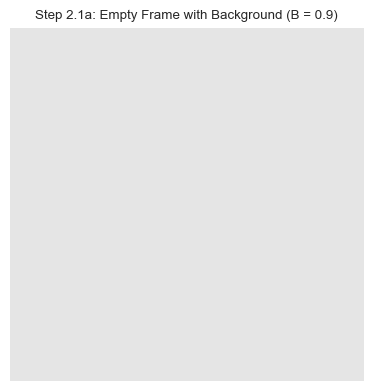


Background level (B): 0.9
Image shape: (512, 512, 3)


In [15]:
%matplotlib inline

# Initialize the frame with uniform background
# Background level B in [0, 1] represents the base intensity
frame = np.full((*cfg.img_size, 3), cfg.background_level, dtype=np.float32)
mt_mask = np.zeros((len(mts), *cfg.img_size), dtype=np.uint16)
gt_data: List[Dict[str, Any]] = []

frame_idx = 0

show_frame(frame, f"Step 2.1a: Empty Frame with Background (B = {cfg.background_level})")
print(f"\nBackground level (B): {cfg.background_level}")
print(f"Image shape: {frame.shape}")

In [16]:
# Apply optional jitter to microtubule base points
# This simulates small positional uncertainties/drift
jitter = (
    np.random.normal(0, cfg.jitter_px, 2).astype(np.float32)
    if cfg.jitter_px > 0
    else np.zeros(2, dtype=np.float32)
)
print(f"Jitter standard deviation: {cfg.jitter_px} px")
print(f"Sampled jitter: {jitter}")

Jitter standard deviation: 0.5 px
Sampled jitter: [ 0.9308454 -0.4355425]


## (2.1) Physical Rendering: PSF Convolution

Given a piecewise-linear MT skeleton (curve $f$), we compute a binary mask $M_S$ marking all pixels intersected by $f$.
This mask is convolved with the **Point Spread Function (PSF)** and scaled:

$$I_{\text{ideal}}(x) = A \cdot (M_S * \text{PSF})(x) + B$$

where:
- $A \in \theta$ is the contrast factor (`tubulus_contrast`)
- $B \in \theta$ is the background intensity
- PSF is modeled as an anisotropic 2D Gaussian with widths $\sigma_h$ (horizontal) and $\sigma_v$ (vertical)

The PSF convolution spreads intensity to neighboring pixels, determining the filament's **physical width** in the rendered image.

### Implementation Detail
Rather than explicit convolution, we rasterize lines by placing small 2D Gaussian spots at regular intervals along each segment.

In [17]:
# Draw microtubules with PSF convolution
# Each MT is rendered by:
# 1. Computing polyline vertices from segments
# 2. Placing Gaussian kernels along each segment (PSF simulation)
# 3. Applying contrast factor A and optional seed coloring

results = []
for mt in mts:
    result = draw_mt(mt, cfg, frame, frame_idx, False, jitter)
    results.append(result)

print(f"\nPSF parameters (theta):")
print(f"  PSF sigma horizontal (sigma_h): {cfg.psf_sigma_h}")
print(f"  PSF sigma vertical (sigma_v): {cfg.psf_sigma_v}")
print(f"  Tubule width variation: +/-{cfg.tubule_width_variation * 100:.0f}%")
print(f"  Contrast factor (A): {cfg.tubulus_contrast}")
print(f"  Seed red channel boost: {cfg.seed_red_channel_boost}")


PSF parameters (theta):
  PSF sigma horizontal (sigma_h): 0.4
  PSF sigma vertical (sigma_v): 0.7
  Tubule width variation: +/-10%
  Contrast factor (A): -0.4
  Seed red channel boost: 0.5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.835452..1.312531].


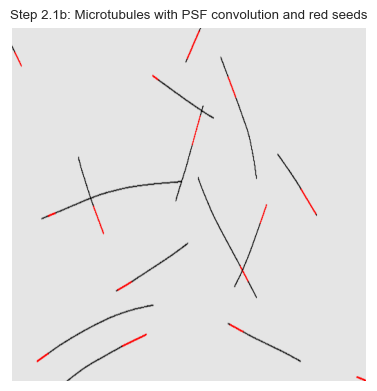


Rendered 15 microtubules
Total segments in ground truth: 208


In [18]:
# Combine all MT renderings into the main frame
# The ideal image is: I_ideal = sum(A * (M_S * PSF)) + B

for i, (local_frame, local_mt_mask, local_seed_mask, gt_info) in enumerate(results):
    frame += local_frame
    if mt_mask is not None and local_mt_mask is not None:
        mt_mask[i] = local_mt_mask
    gt_data.extend(gt_info)

show_frame(frame, "Step 2.1b: Microtubules with PSF convolution and red seeds")
print(f"\nRendered {len(mts)} microtubules")
print(f"Total segments in ground truth: {len(gt_data)}")

---
## (2.2) Artifact Simulation

Realistic microscopy images contain various distractor features. We simulate:

1. **Fixed spots**: Stationary artifacts (dust particles, debris) that remain constant across frames
2. **Moving spots**: Dynamic artifacts with random motion (vesicles, organelles)
3. **Random spots**: Per-frame noise (transient artifacts)

Each spot type can be:
- **Circular**: Simple Gaussian blobs
- **Polygonal**: Irregular convex shapes for more realistic artifacts

Parameters include intensity range, size distribution, and blur kernel size.

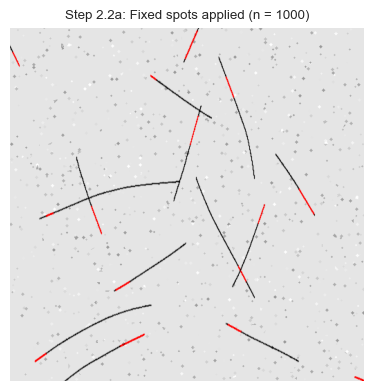


Fixed spot parameters:
  Count: 1000
  Intensity range: [-0.3, 0.1]
  Radius range: [1, 2] px
  Polygon probability: 0.1


In [19]:
# Apply fixed spots (stationary artifacts)
# These represent dust, debris, or other static features
frame = fixed_spot_generator.apply(frame)

show_frame(frame, f"Step 2.2a: Fixed spots applied (n = {fixed_spot_generator.n_spots})")
print(f"\nFixed spot parameters:")
print(f"  Count: {cfg.fixed_spots.count}")
print(f"  Intensity range: [{cfg.fixed_spots.intensity_min}, {cfg.fixed_spots.intensity_max}]")
print(f"  Radius range: [{cfg.fixed_spots.radius_min}, {cfg.fixed_spots.radius_max}] px")
print(f"  Polygon probability: {cfg.fixed_spots.polygon_p}")

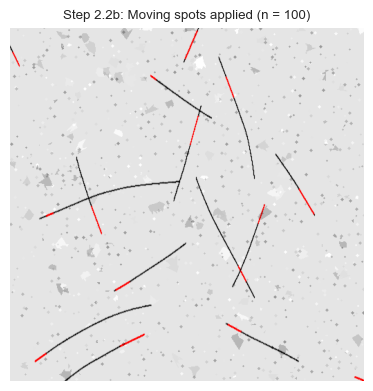


Moving spot parameters:
  Count: 100
  Intensity range: [-0.2, 0.1]
  Radius range: [3, 8] px
  Max step size: 5 px/frame


In [20]:
# Apply moving spots (dynamic artifacts)
# These simulate vesicles, organelles, or other moving structures
frame = moving_spot_generator.apply(frame)
moving_spot_generator.update()  # Update positions for next frame

show_frame(frame, f"Step 2.2b: Moving spots applied (n = {moving_spot_generator.n_spots})")
print(f"\nMoving spot parameters:")
print(f"  Count: {cfg.moving_spots.count}")
print(f"  Intensity range: [{cfg.moving_spots.intensity_min}, {cfg.moving_spots.intensity_max}]")
print(f"  Radius range: [{cfg.moving_spots.radius_min}, {cfg.moving_spots.radius_max}] px")
print(f"  Max step size: {cfg.moving_spots.max_step} px/frame")

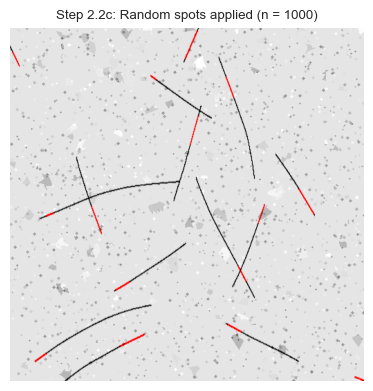


Random spot parameters:
  Count: 1000
  Intensity range: [-0.3, 0.1]


In [21]:
# Apply random spots (per-frame transient artifacts)
frame = SpotGenerator.apply_random_spots(frame, cfg.random_spots)

show_frame(frame, f"Step 2.2c: Random spots applied (n = {cfg.random_spots.count})")
print(f"\nRandom spot parameters:")
print(f"  Count: {cfg.random_spots.count}")
print(f"  Intensity range: [{cfg.random_spots.intensity_min}, {cfg.random_spots.intensity_max}]")

---
## (2.3) Noise Addition

The noise operator $\nu_\theta$ combines multiple perturbation processes:

### Signal-Dependent Noise (Poisson/Shot Noise)
Models photon counting statistics in the detector:
$$I_{\text{shot}}(x) = \frac{\text{Poisson}(I(x) \cdot QE)}{QE}$$
where $QE$ is the quantum efficiency parameter.

### Signal-Independent Noise (Gaussian/Read Noise)
Models electronic noise in the detector:
$$I_{\text{final}}(x) = I_{\text{shot}}(x) + \mathcal{N}(0, \sigma^2)$$

### Channel-Specific Noise
Additional noise on specific color channels (e.g., red channel for seed visualization).

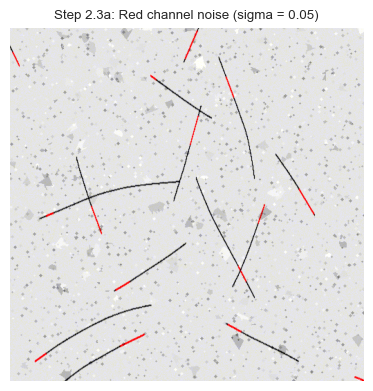

Red channel noise std: 0.05


In [22]:
# Apply red channel noise (channel-specific distortion)
# This can simulate chromatic aberration or channel-specific detector noise
if cfg.red_channel_noise_std > 0.0:
    red_noise = np.random.normal(0, cfg.red_channel_noise_std, frame.shape[:2]).astype(np.float32)
    red_ch_idx = 2  # OpenCV uses BGR format
    frame[..., red_ch_idx] += red_noise
    frame[..., red_ch_idx] = np.clip(frame[..., red_ch_idx], 0, 1)

    show_frame(frame, f"Step 2.3a: Red channel noise (sigma = {cfg.red_channel_noise_std})")
    print(f"Red channel noise std: {cfg.red_channel_noise_std}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.44].


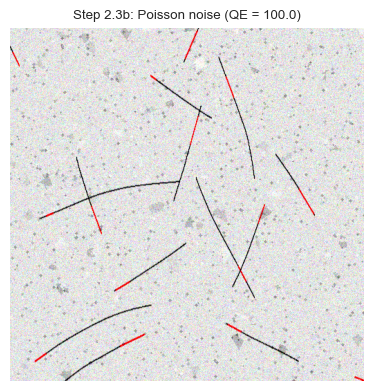


Poisson noise parameters:
  Quantum efficiency (QE): 100.0
  Higher QE = more photons = less relative noise


In [23]:
# Apply Poisson (shot) noise - signal-dependent
# Models photon counting statistics: I_shot = Poisson(I * QE) / QE
if cfg.quantum_efficiency > 0:
    frame[frame < 0] = 0  # Clamp negative values before Poisson noise
    frame = np.random.poisson(frame * cfg.quantum_efficiency) / cfg.quantum_efficiency

    show_frame(frame, f"Step 2.3b: Poisson noise (QE = {cfg.quantum_efficiency})")
    print(f"\nPoisson noise parameters:")
    print(f"  Quantum efficiency (QE): {cfg.quantum_efficiency}")
    print(f"  Higher QE = more photons = less relative noise")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3378760814666748..2.3652670049667357].


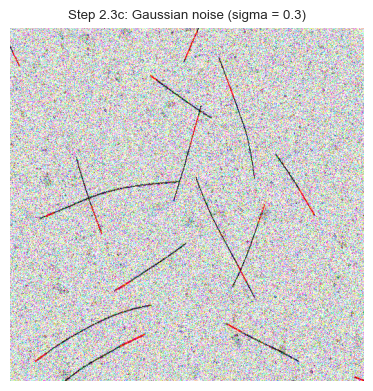


Gaussian noise std: 0.3


In [24]:
# Apply Gaussian (read) noise - signal-independent
# Models electronic/thermal noise: I_final = I_shot + N(0, sigma^2)
if cfg.gaussian_noise > 0.0:
    frame += np.random.normal(0, cfg.gaussian_noise, frame.shape).astype(np.float32)

    show_frame(frame, f"Step 2.3c: Gaussian noise (sigma = {cfg.gaussian_noise})")
    print(f"\nGaussian noise std: {cfg.gaussian_noise}")

---
## (2.4) Global Distortions

Spatially-varying effects that match real microscopy conditions:

### Vignetting
Radial intensity falloff from the center:
$$V(x, y) = 1 - s \cdot \left(\left(\frac{x - c_x}{w/2}\right)^2 + \left(\frac{y - c_y}{h/2}\right)^2\right)$$
where $s$ is the vignetting strength.

### Global Blur
Gaussian blur to simulate optical imperfections or defocus:
$$I_{\text{blur}} = I * G(\sigma_{\text{blur}})$$

### Contrast and Brightness
Final intensity adjustments to match target image statistics.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.289672652857007..2.273608589560081].


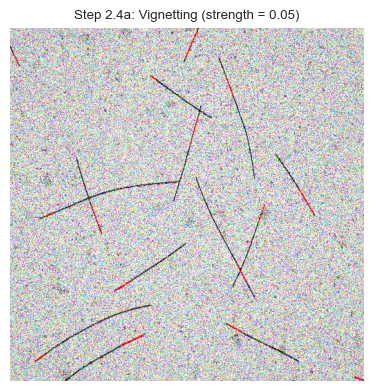


Vignetting strength: 0.05
Vignette range: [0.900, 1.000]


In [25]:
# Apply vignetting (radial intensity falloff)
# V(x,y) = 1 - s * ((x-cx)^2 + (y-cy)^2) / (max_dist)^2
vignette = compute_vignette(cfg)
frame *= vignette[..., np.newaxis]

show_frame(frame, f"Step 2.4a: Vignetting (strength = {cfg.vignetting_strength})")
print(f"\nVignetting strength: {cfg.vignetting_strength}")
if isinstance(vignette, np.ndarray):
    print(f"Vignette range: [{vignette.min():.3f}, {vignette.max():.3f}]")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.31525363016554137..1.5246109962104128].


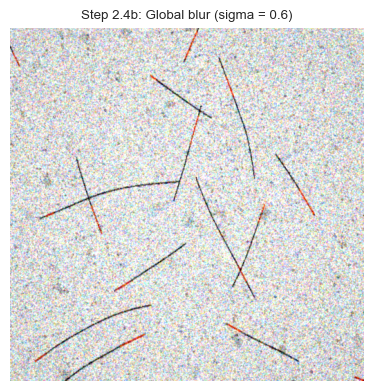


Global blur sigma: 0.6


In [26]:
# Apply global Gaussian blur
# Simulates optical imperfections, slight defocus, or motion blur
frame = apply_global_blur(frame, cfg)

show_frame(frame, f"Step 2.4b: Global blur (sigma = {cfg.global_blur_sigma})")
print(f"\nGlobal blur sigma: {cfg.global_blur_sigma}")

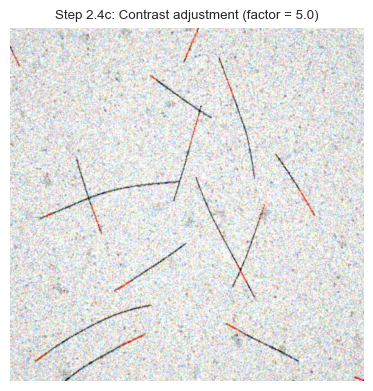


Global contrast factor: 5.0


In [27]:
# Apply contrast adjustment
# Scales intensity values to match target dynamic range
if cfg.global_contrast > 0.0:
    frame = apply_contrast(frame, cfg.global_contrast)

    show_frame(frame, f"Step 2.4c: Contrast adjustment (factor = {cfg.global_contrast})")
    print(f"\nGlobal contrast factor: {cfg.global_contrast}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05..1.05].


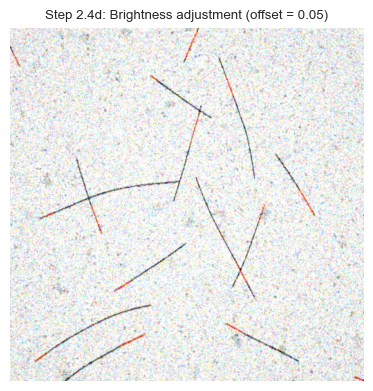


Global brightness offset: 0.05


In [28]:
# Apply brightness adjustment
# Shifts intensity values to match target mean
if cfg.global_brightness > 0.0:
    frame = apply_brightness(frame, cfg.global_brightness)

    show_frame(frame, f"Step 2.4d: Brightness adjustment (offset = {cfg.global_brightness})")
    print(f"\nGlobal brightness offset: {cfg.global_brightness}")

---
# Final Result

The complete pipeline produces the final image $I$:

$$I = \nu_\theta(I_{\text{ideal}})$$

where $\nu_\theta$ encapsulates all noise and artifact processes.

Together, the pipeline defines a probability distribution $P_\theta(I)$ over synthetic images, enabling:
- **Training data generation** for deep learning models
- **Benchmark creation** with known ground truth
- **Parameter optimization** to match real data distributions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05..1.05].


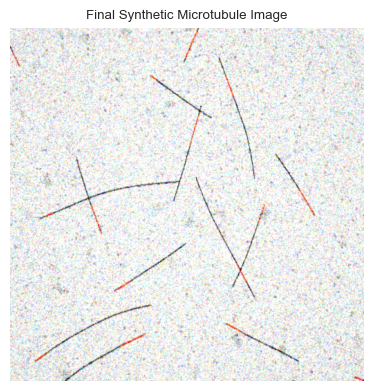


GENERATION COMPLETE

Image statistics:
  Min intensity: 0.0500
  Max intensity: 1.0500
  Mean intensity: 0.9287
  Std intensity: 0.1081

Generated 15 microtubules with 208 total segments


In [29]:
# Display final result
show_frame(frame, "Final Synthetic Microtubule Image")

print("\n" + "=" * 60)
print("GENERATION COMPLETE")
print("=" * 60)
print(f"\nImage statistics:")
print(f"  Min intensity: {frame.min():.4f}")
print(f"  Max intensity: {frame.max():.4f}")
print(f"  Mean intensity: {frame.mean():.4f}")
print(f"  Std intensity: {frame.std():.4f}")
print(f"\nGenerated {len(mts)} microtubules with {len(gt_data)} total segments")

---
# Summary: Parameter Set $\theta$

The complete parameter set $\theta$ used in this generation:

In [30]:
print("\n" + "=" * 60)
print("PARAMETER SET theta SUMMARY")
print("=" * 60)

print("\n[1] GEOMETRY PARAMETERS")
print(f"  Number of MTs: {cfg.num_microtubule}")
print(f"  MT length range: [{cfg.microtubule_length_min}, {cfg.microtubule_length_max}]")
print(f"  Seed length range: [{cfg.base_segment_length_min}, {cfg.base_segment_length_max}]")
print(f"  Segment length: {cfg.tail_segment_length}")
print(
    f"  Bending Gamma(alpha, beta): ({cfg.bending_angle_gamma_shape}, {cfg.bending_angle_gamma_scale})"
)
print(f"  Max sign changes: {cfg.max_angle_sign_changes}")
print(f"  Flip probability: {cfg.prob_to_flip_bend}")

print("\n[2.1] PHYSICAL RENDERING")
print(f"  PSF sigma (h, v): ({cfg.psf_sigma_h}, {cfg.psf_sigma_v})")
print(f"  Background level B: {cfg.background_level}")
print(f"  Contrast A: {cfg.tubulus_contrast}")
print(f"  Seed boost: {cfg.seed_red_channel_boost}")

print("\n[2.2] ARTIFACT PARAMETERS")
print(f"  Fixed spots: {cfg.fixed_spots.count}")
print(f"  Moving spots: {cfg.moving_spots.count}")
print(f"  Random spots: {cfg.random_spots.count}")

print("\n[2.3] NOISE PARAMETERS")
print(f"  Quantum efficiency: {cfg.quantum_efficiency}")
print(f"  Gaussian noise sigma: {cfg.gaussian_noise}")
print(f"  Red channel noise sigma: {cfg.red_channel_noise_std}")

print("\n[2.4] GLOBAL DISTORTIONS")
print(f"  Vignetting strength: {cfg.vignetting_strength}")
print(f"  Global blur sigma: {cfg.global_blur_sigma}")
print(f"  Contrast factor: {cfg.global_contrast}")
print(f"  Brightness offset: {cfg.global_brightness}")
print(f"  Jitter sigma: {cfg.jitter_px}")


PARAMETER SET theta SUMMARY

[1] GEOMETRY PARAMETERS
  Number of MTs: 15
  MT length range: [100, 200]
  Seed length range: [10.0, 50.0]
  Segment length: 10.0
  Bending Gamma(alpha, beta): (1.0, 0.02)
  Max sign changes: 5
  Flip probability: 0.9

[2.1] PHYSICAL RENDERING
  PSF sigma (h, v): (0.4, 0.7)
  Background level B: 0.9
  Contrast A: -0.4
  Seed boost: 0.5

[2.2] ARTIFACT PARAMETERS
  Fixed spots: 1000
  Moving spots: 100
  Random spots: 1000

[2.3] NOISE PARAMETERS
  Quantum efficiency: 100.0
  Gaussian noise sigma: 0.3
  Red channel noise sigma: 0.05

[2.4] GLOBAL DISTORTIONS
  Vignetting strength: 0.05
  Global blur sigma: 0.6
  Contrast factor: 5.0
  Brightness offset: 0.05
  Jitter sigma: 0.5
